# Visualize flow data availability


In [1]:
#import os
import sys
#import shutil
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Merged shape
merged_shape_folder = cs.read_from_config(config_file, 'merged_shp_dir')
merged_shape_name   = cs.read_from_config(config_file, 'merged_shp_name')

In [4]:
# Specify the paths
basins_path = Path(data_path) / cs_basin_folder
merged_shape_path = Path(data_path) / cs_basin_folder / merged_shape_folder

### Data loading

In [5]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [6]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object}) 

In [7]:
# Shapefiles
shp = gpd.read_file(merged_shape_path / 'merged_lumped_outlines.shp')

## Calculate statistics we're interested in

In [8]:
# Check that shapefiles entries and metadata entries are in the same order
assert (shp['Station_id'] == cs_meta['Station_id']).all()

In [9]:
# Get the number of missing flow observations (-1 indicates no observations available at all)
shp = shp.join(cs_meta['flow_obs_missing_hourly'])

In [18]:
# Find the duration of each time series (start to finish)
shp['flow_obs_duration'] = pd.to_datetime(cs_meta['flow_obs_availability_end']) - \
                                pd.to_datetime(cs_meta['flow_obs_availability_start'])

In [21]:
# Convert the number of missing flow observations into a percentage of total
shp['flow_obs_missing_frac'] = shp['flow_obs_missing_hourly'] / (shp['flow_obs_duration'] / pd.Timedelta(hours=1))

## Plot data availability per basin

In [11]:
# Reproject
old_crs = 'epsg:4326'
new_crs = 'esri:102003' # Should be Albers Equal Area Conic
shp = shp.set_crs(old_crs)
shp = shp.to_crs(new_crs)

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [13]:
# Make a cmap
cmap = mpl.colormaps.get_cmap('Purples')

In [15]:
# Create a normalization scale
logmin = 1 # We're dealing with integers (data = number of missing values, so this should work
norm = colors.LogNorm(vmin=logmin, vmax=shp['flow_obs_missing_hourly'].max())

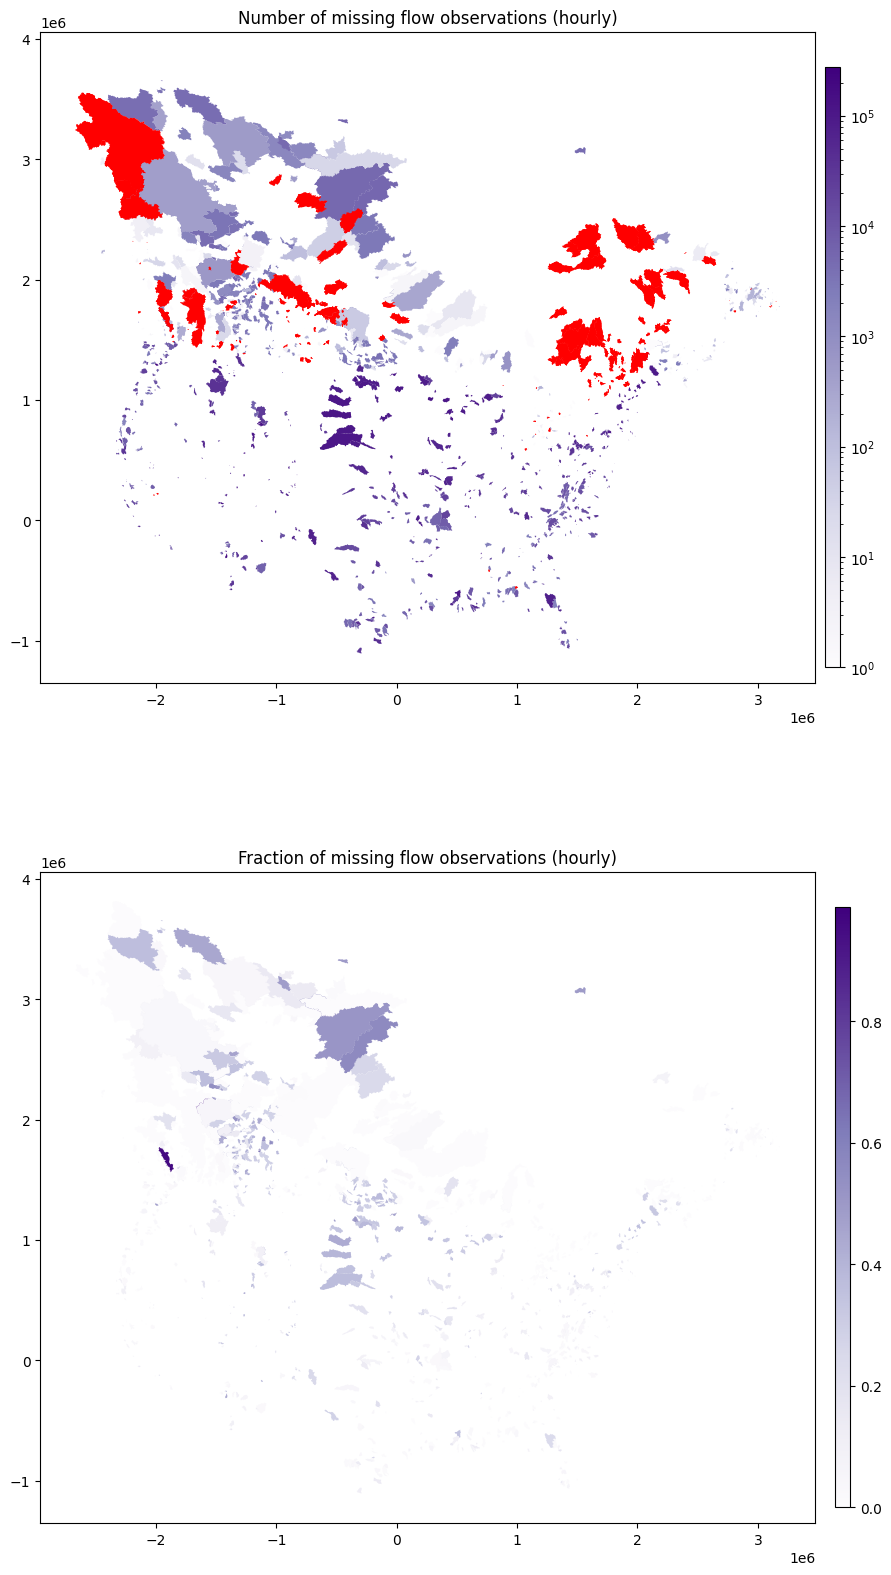

In [22]:
# Plot missing values (no data in red)
fig, ax = plt.subplots(2,1, figsize=(10, 20))

column = 'flow_obs_missing_hourly'
mask_no_data = shp[column] == -1 
shp[mask_no_data].plot(color='red', ax=ax[0])
shp[~mask_no_data].plot(column=column, cmap=cmap, norm=norm, legend=True, ax=ax[0], cax=fig.add_axes([0.91, 0.55, 0.015, 0.3]))
ax[0].set_title('Number of missing flow observations (hourly)')

column = 'flow_obs_missing_frac'
shp[mask_no_data].plot(color='red', ax=ax[0])
shp[~mask_no_data].plot(column=column, cmap=cmap, legend=True, ax=ax[1], cax=fig.add_axes([0.92, 0.13, 0.015, 0.3]))
ax[1].set_title('Fraction of missing flow observations (hourly)')

plt.show()

## CDFs

In [43]:
# Calculate durations
cdf_full = shp['flow_obs_duration'].sort_values().reset_index(drop=True).dropna().copy()
cdf_data = (shp['flow_obs_duration'] - pd.to_timedelta(shp['flow_obs_missing_hourly'], unit='h')).sort_values().reset_index(drop=True).dropna().copy()

(0.9, 1.05)

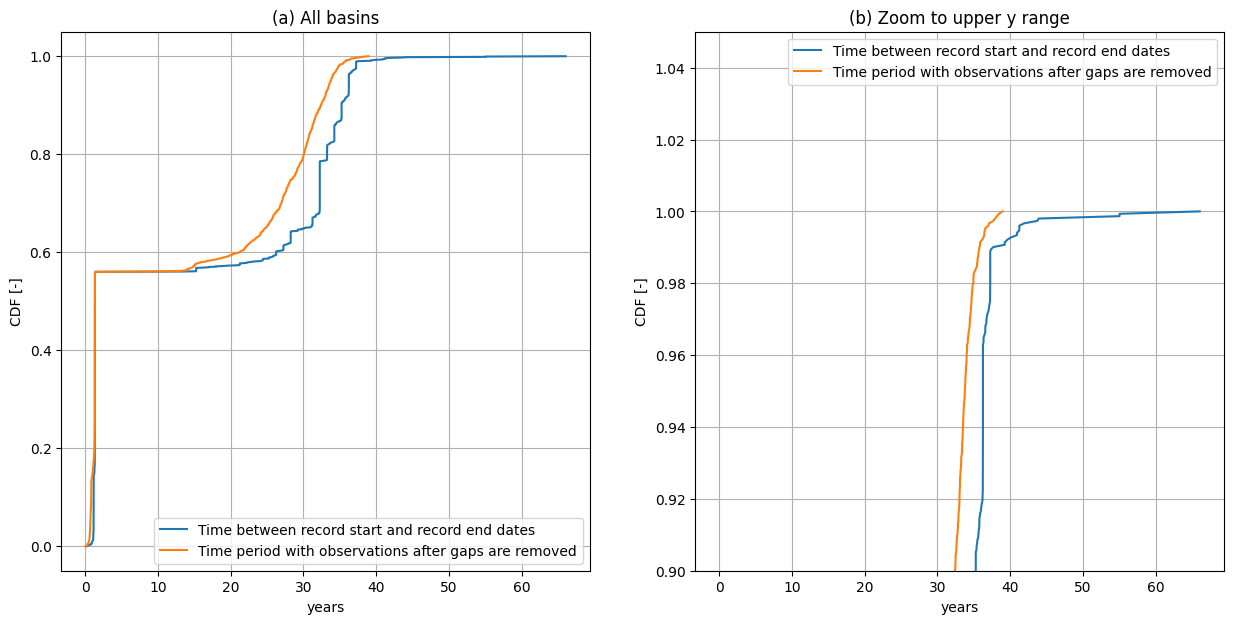

In [70]:
# Create a y-axis
y = np.linspace(0,1,num=len(cdf_full))

# Plot the CDFs
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(cdf_full/pd.Timedelta(days=365.25), y, label='Time between record start and record end dates')
ax[0].plot(cdf_data/ pd.Timedelta(days=365.25),y, label='Time period with observations after gaps are removed')
ax[0].legend()
ax[0].set_xlabel('years')
ax[0].set_ylabel('CDF [-]')
ax[0].set_title('(a) All basins')
ax[0].grid()

ax[1].plot(cdf_full/pd.Timedelta(days=365.25), y, label='Time between record start and record end dates')
ax[1].plot(cdf_data/ pd.Timedelta(days=365.25),y, label='Time period with observations after gaps are removed')
ax[1].legend()
ax[1].set_xlabel('years')
ax[1].set_ylabel('CDF [-]')
ax[1].set_title('(b) Zoom to upper y range')
ax[1].grid()
ax[1].set_ylim([0.9,1.05])

## Does flow observation start fall outside forcing data availability?

In [72]:
forcing_s = pd.to_datetime('1950-01-01 00:00')
forcing_e = pd.to_datetime('2019-12-31 23:00')

In [78]:
# Any flow obs start before forcing availability?
(pd.to_datetime(cs_meta['flow_obs_availability_start']) < forcing_s).any()

False

In [79]:
# Any flow obs end after forcing availability?
(pd.to_datetime(cs_meta['flow_obs_availability_end']) > forcing_e).any()

True